<a href="https://colab.research.google.com/github/alee-ds-star/de/blob/academic/Academic%20Work/Practical%20Machine%20Learning/Deep%20Learning%20for%20Computer%20Vision/Convolutional_Neural_Networks_Cats_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Appendix/Code:**

## **Image Classification Using Convolutional Neural Networks (CNN):** 
*  In this experiment, a Dogs versus Cats data set will be used. The data set contains data for thousands of color images for dogs and cats. 
* Multiple convolutional neural networks will be built and tested to classify the images in the dataset. Train and test set accuracies and losses will be captured, as well as processing times for training each model. The number of layers and nodes per layer will serve as key parameters that will differentiate each model, and the accuracies, loss, and processing times will be compared. Log loss will be the main metric used to compare models. 
* Each image is a part of 2 folders, one for training and the other for testing. Images in the training folder has labels as a part of the file name.
* The training folder contains 25,000 images of dogs and cats. The test folder contains 12,500 images, named according to a numeric id [2].
* For each image in the test set, a probability is predicted for dogs and cats.
*  Image classifiers will be developed using convolutional layers and max pooling layers that can be used to predict which of the images is a cat or a dog.
*   The goal of this benchmark experiment is to assess the effectiveness of convolutional neural networks using different topologies. 
*   Benchmark experiment is based on a 2x2 factorial design with two levels on each of two experimental factors. 
* Models will be evaluated on the test set that will be scored by a third party (Kaggle).


## **What is a Convolutional Neural Network (CNN)?**
Convolutional Neural Networks, or CNNs, are deep learning algorithms that are inspired by our own brain's visual cortex. This variant neural network, from  a fully connected deep neural network, power image services, self-driving cars, and more. They are also used in voice recognition and natural language processing. CNNs are modeled off of our visual cortex in that they react to local receptive fields, where receptive fields of different neurons overlap, and together they tie together the whole receptive field [1]. Higher-level neurons have larger receptive fields and are based on the outputs of neighboring lower-level neurons, and each neuron is connected to a few neurons from the previous layer. In other words, neurons in the first convolutional layer are not connected to every single pixel in their receptive fields. That is each neuron in the subsequent layer is connected only to neurons located within a small rectangle from the previous layer. This architecture is able to detect complex patterns in almost any area of the visual field.

In a CNN a neuron's weights are represented as a small image the size of the receptive field. They are called filters or convolutional kernels. A filter will generally have neurons using these weights ignore everything in their receptive field, such as in a representation of a black shape with a white line that crosses through it. The neurons will ignore everything except for the white line. A layer of neurons using the same filter, is thus called a feature map, which highlights the areas in an image that are most similar to the filter. A CNN during training finds the most useful filters for its task, and combines them into more complex patterns [1]. A convolutional layer will have stacks of multiple feature maps where different feature maps will have different parameters allowing it to detect features anywhere in its inputs. Once a CNN has learned to distinguish a pattern in one location, it can distinguish it from another location. Additionally, input images are also composed of multiple sublayers, representing one color per channel.    

On top of convolutional layers, a CNN will generally also have layers called pooling layers, that subsample, or shrink the image to reduce the computational load, and the number of parameters to reduce overfitting [1]. As with convolutional layers, a pooling layer is connected to the outputs of a limited number of neurons in the previous layer, yet it will have no weights. It aggregates all the inputs using a function such as the max or mean. A typical CNN architecture will have convolutional layers, followed by pooling layers, and a feed forward neural network that is added at the end, which are composed of a few fully connected layers. A final layer will then output the prediction.     


## **Initial Setup:**

### **Import Libraries:**

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
#TensorFlow 
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import os, os.path, shutil
from google.colab import files
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, load_img
from keras import layers
from keras.models import load_model
from keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
#For math
import numpy as np
#For data
import pandas as pd
#For visualization
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
#For modeling
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split
#Timer for execution time
import time
from timeit import default_timer as timer
#For random shuffling
import random
#For data transfer
import json
#For logging
from datetime import datetime

### **TensorBoard Tunnel for Visualization on Local Machine:**

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-11-10 08:45:04--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.203.32.42, 3.217.182.206, 52.44.216.116, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.203.32.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  11.7MB/s    in 1.1s    

2019-11-10 08:45:06 (11.7 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://e08d1a40.ngrok.io


In [0]:
# For logging
log = './log' + '/' +  datetime.now().strftime("%Y%m%d-%H%M%S") + '/'
tbCallBack = tf.keras.callbacks.TensorBoard(log_dir=log)

### **Define Functions:**

**Confusion Matrix:**

In [0]:
# Used for confusion matrix visualization
def plot_confusion_matrix(matrix, annot, axes, color): 
    sns.heatmap(matrix, annot=annot,ax=axes, fmt='g', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'], cmap=color); #annot=True to annotate cells
    b, t = plt.ylim() # Fix cutoff
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    return

**Classification Report Heatmap:**

In [0]:
# Used to visualize classification reports for better visibility
def plot_classification_report(y_tru, y_prd, figsize=(10, 10), ax=None):

    plt.figure(figsize=figsize)

    xticks = ['Precision', 'Recall', 'f1-score']
    #yticks = list(np.unique(y_tru))
    yticks = ['Cat', 'Dog']
    yticks += ['AVG']

    rep = np.array(precision_recall_fscore_support(y_tru, y_prd))[:3,:].T
    avg = np.mean(rep, axis=0)
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    sns.heatmap(rep, annot=True, cbar=True, fmt='g', cmap='Blues', xticklabels=xticks, yticklabels=yticks, ax=ax)
    b, t = plt.ylim() # Fix cutoff
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values

**Custom Metrics for F1 Scores, Precision, and Recall:**

In [0]:
# Function for precision, recall, and f1 scores

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### **Data Preparation:**

**Import Images:**

In [0]:
!mkdir .kaggle

In [0]:
ls -a

./  ../  .config/  .kaggle/  sample_data/


In [0]:
token = {"username":"drew21717","key":"6c5cccc2dd96957e7b43ea8f8cc3444b"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!chmod 600 /content/.kaggle/kaggle.json

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 99% 537M/544M [00:07<00:00, 53.0MB/s]
100% 544M/544M [00:07<00:00, 72.3MB/s]
 98% 266M/271M [00:02<00:00, 112MB/s] 
100% 271M/271M [00:02<00:00, 128MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 101MB/s]


In [0]:
!unzip \*.zip

In [0]:
!ls -a

.	 .kaggle		submission_1B.csv  test.zip	train_valid
..	 sample_data		submission.csv	   train	train.zip
.config  sample_submission.csv	test_files	   train_train


### **Split Training Data Into Train Set and Validation Set:**

In [0]:
file_names = os.listdir('./train')

In [0]:
len(file_names)

25000

**Randomly Shuffle Images and Split:**

In [0]:
#Function to split training file into a training set and validation set. 
percentage_of_train = 0.75    

def split_dataset_in_train_and_valid( filenames, percentage):
  
  total_images = len(filenames)
  total_train = int(total_images * percentage_of_train)
  
  set_train = []
  
  random.seed(42)
  while (len(set_train) != total_train):     
    num_image = random.randrange(total_images)
    if num_image not in set_train:
      set_train.append(num_image)

  set_valid = []
  for i in range(total_images):
    if i not in set_train:
      set_valid.append(i)
    
  images_train =[]
  for i in set_train:    
    images_train.append(filenames[i])
   
  images_valid =[]
  for i in set_valid:    
    images_valid.append(filenames[i])
  
  return (images_train, images_valid)

In [0]:
train_train_valid = (split_dataset_in_train_and_valid (file_names, percentage_of_train))

In [0]:
train_train = train_train_valid[0]
train_val = train_train_valid[1]

**Make Subdirectories and Move Images:**

In [0]:
os.makedirs('./train_train')

In [0]:
os.makedirs('./train_valid')

In [0]:
for i in train_train:
  shutil.move('./train/'+ i, './train_train')

In [0]:
for i in train_val:
  shutil.move('./train/'+ i, './train_valid')

In [0]:
len(os.listdir('./train_train'))

18750

In [0]:
len(os.listdir('./train_valid'))

6250

**Split Training Set, Validation Set, and Test Set Into Class Subfolders:**

In [0]:
# Split training set into classes

folder_path = './train_train'

images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

for image in images:
    folder_name = image.split('.')[0]

    new_path = os.path.join(folder_path, folder_name)
    if not os.path.exists(new_path):
        os.makedirs(new_path)

    old_image_path = os.path.join(folder_path, image)
    new_image_path = os.path.join(new_path, image)
    shutil.move(old_image_path, new_image_path)

In [0]:
# Split validation set into classes

folder_path = './train_valid'

images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

for image in images:
    folder_name = image.split('.')[0]

    new_path = os.path.join(folder_path, folder_name)
    if not os.path.exists(new_path):
        os.makedirs(new_path)

    old_image_path = os.path.join(folder_path, image)
    new_image_path = os.path.join(new_path, image)
    shutil.move(old_image_path, new_image_path)

**Create Subdirectory for Test Set Images:**

In [0]:
len(os.listdir('./test/'))

12500

In [0]:
os.mkdir('./test_files')
os.mkdir('./test_files/test_images')

In [0]:
image_files = os.listdir('./test')
for i in image_files:
  shutil.move('./test/'+ i, './test_files/test_images')

In [0]:
len(os.listdir('./test_files/test_images'))

12500

In [0]:
shutil.rmtree('./test')

**The Data:**

In [0]:
num_cats_tr = len(os.listdir('train_train/cat'))
num_dogs_tr = len(os.listdir('train_train/dog'))

num_cats_val = len(os.listdir('./train_valid/cat'))
num_dogs_val = len(os.listdir('./train_valid/dog'))

train_size = len(os.listdir('./train_train/cat')) +len(os.listdir('./train_train/dog'))
val_size = len(os.listdir('./train_valid/cat')) +len(os.listdir('./train_valid/dog'))

print('Total training cat images:', num_cats_tr)
print('Total training dog images:', num_dogs_tr)

print('Total validation cat images:', num_cats_val)
print('Total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", train_size)
print("Total validation images:", val_size)
print("Total test images:", len(os.listdir('./test_files/test_images')))

Total training cat images: 9399
Total training dog images: 9351
Total validation cat images: 3101
Total validation dog images: 3149
--
Total training images: 18750
Total validation images: 6250
Total test images: 12500


### **Image Scaling for Test Set:**

In [0]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [0]:
test_image_generator = ImageDataGenerator(rescale=1./255)

In [0]:
test_data_gen = test_image_generator.flow_from_directory(batch_size=1,
                                                           directory=r'./test_files/',
                                                           shuffle=False,
                                                           color_mode='rgb',
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode=None,
                                                           seed=42)

Found 12500 images belonging to 1 classes.


### **Image Scaling For Training and Validation Sets:**

In [0]:
batch_size = 32
epochs = 50

In [0]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [0]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory='./train_train',
                                                           shuffle=True,
                                                           color_mode='rgb',
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary',
                                                           seed=42)


Found 18750 images belonging to 2 classes.


In [0]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory='./train_valid',
                                                              shuffle=True,
                                                              color_mode='rgb',
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary',
                                                              seed=42
                                                              )

Found 6250 images belonging to 2 classes.


## **Visualizing the Images:**

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [0]:
sample_training_images, _ = next(train_data_gen)

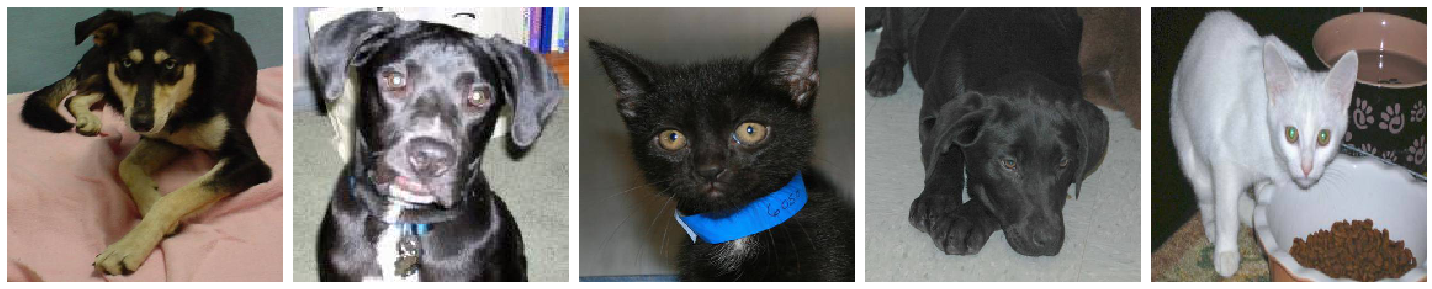

In [0]:
plotImages(sample_training_images[:5])

## **Convulutional Neural Network Experimental Factor 1:**
 - Five convolutional layers, five max pooling layers, and one fully connected layer was used in the first experimental factor along with the output layer. Two models were used in the first experimental factor. 
 - Default settings were used for the max pooling layers. Convolutional layers all had zero padding, using relu activation. Different nodes were used for each convolutional layer going from 3, 64, 128, and ending at 512.
 - The fully connected layer had 512 nodes, and activation was also set to relu.
 - The output layer used sigmoid activation, as this was the recommended activation for binary classification.
 - While the second model used basically the same layers (had an added average pooling layer at the end), it utilized regularization and batch normalization to prevent overfitting. 
 - For the second model, batch normalization was used after every max pooling layer and for the fully connected layer, and a dropout of 0.25 or 0.50 was also used.
 - Early stopping was used for both models that were set to the least amount of loss. Models were ran over 50 epochs with a batch size of 32, with 585 steps per epoch for training, and 195 steps for validation. 
 - Results showed that although the second model took almost double the processing time (13.75 minutes versus 22.63), there were significant improvements in accuracy and loss (88.46% and 0.3161 versus 91.74% and 0.2016).
 - Though additional regularization techniques and tweaks in hyperparameter settings could have been used, employing dropout and batch normalization showed a marked difference, indicating that at the expense of time and resources, it may be a worthwhile expenditure. 

### **Model 1A:**
 - No regularization or normalization.
 - Five convolutional layers, five max pooling layers, and one fully connected layer along with the output layer. 
 - Nodes for convolutional layers are 3, 64, 128, and 512.
 - Fully connected layer has 512 nodes.
 - Early stopping set to 5 epochs where the least amount of loss is restored for testing.


In [0]:
# Set up model layers
tf.keras.backend.clear_session()

model_1A = Sequential([
    Conv2D(3, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(256, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(512, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [0]:
#Compile model and define optimizer, loss, and, metrics
model_1A.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',f1_m, precision_m, recall_m])

In [0]:
model_1A.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 3)       84        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       2

In [0]:
#Fit model with execution time recorded
start = timer()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
history_1A = model_1A.fit_generator(
    train_data_gen,
    steps_per_epoch=train_size // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=val_size // batch_size,
    callbacks = [es] #tbCallBack]
)
end = timer()
exec_time_model_1a = (end - start)/60

print('Total Processing Time in Minutes:', exec_time_model_1a)

Epoch 1/50
585/585 [==============================] - 74s 126ms/step - loss: 0.6112 - accuracy: 0.6534 - f1_m: 0.6128 - precision_m: 0.6741 - recall_m: 0.6189 - val_loss: 0.6312 - val_accuracy: 0.6293 - val_f1_m: 0.7154 - val_precision_m: 0.5801 - val_recall_m: 0.9529
Epoch 2/50
585/585 [==============================] - 69s 118ms/step - loss: 0.4921 - accuracy: 0.7637 - f1_m: 0.7567 - precision_m: 0.7678 - recall_m: 0.7652 - val_loss: 0.4440 - val_accuracy: 0.7933 - val_f1_m: 0.7932 - val_precision_m: 0.7829 - val_recall_m: 0.8125
Epoch 3/50
585/585 [==============================] - 69s 118ms/step - loss: 0.4019 - accuracy: 0.8166 - f1_m: 0.8119 - precision_m: 0.8150 - recall_m: 0.8247 - val_loss: 0.3753 - val_accuracy: 0.8313 - val_f1_m: 0.8387 - val_precision_m: 0.7882 - val_recall_m: 0.9042
Epoch 4/50
585/585 [==============================] - 68s 117ms/step - loss: 0.3217 - accuracy: 0.8597 - f1_m: 0.8567 - precision_m: 0.8586 - recall_m: 0.8674 - val_loss: 0.4440 - val_accuracy:

In [0]:
tf.keras.backend.clear_session()

**Metrics and Visualizations:**

In [0]:
stats_train_1A = model_1A.evaluate(train_data_gen, verbose=1)
stats_val_1A = model_1A.evaluate(val_data_gen, verbose=1)  

196/196 [==============================] - 19s 96ms/step - loss: 0.3161 - accuracy: 0.8846 - f1_m: 0.8804 - precision_m: 0.8767 - recall_m: 0.8932


**Learning Curves:**
 - Learning curves below show signs of overfitting, as loss increases over time, while training accuracy starts to plateau.

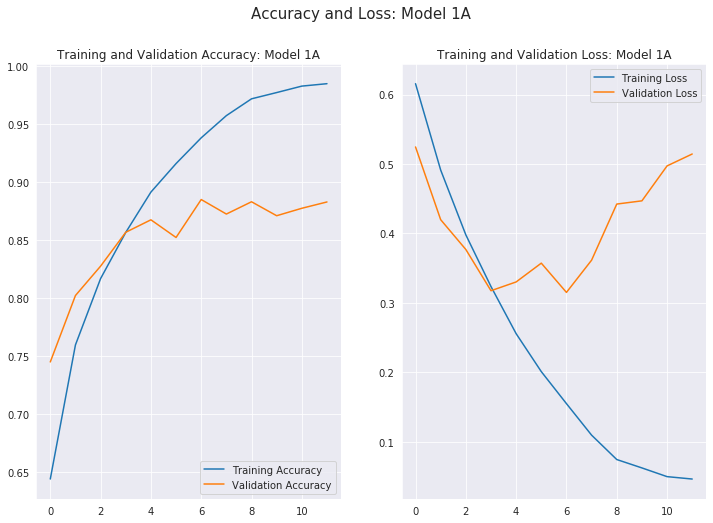

In [0]:
acc_1A = history_1A.history['accuracy']
val_acc_1A = history_1A.history['val_accuracy']

loss_1A = history_1A.history['loss']
val_loss_1A = history_1A.history['val_loss']

epochs_range = range(12)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_1A, label='Training Accuracy')
plt.plot(epochs_range, val_acc_1A, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy: Model 1A')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_1A, label='Training Loss')
plt.plot(epochs_range, val_loss_1A, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss: Model 1A')

plt.suptitle('Accuracy and Loss: Model 1A', fontsize='15')

plt.show()

**F1 Scores, Precision, and Recall:**
 - F1 scores, precision and recall show slippage over time. This is also an indication of an overfitting model. 

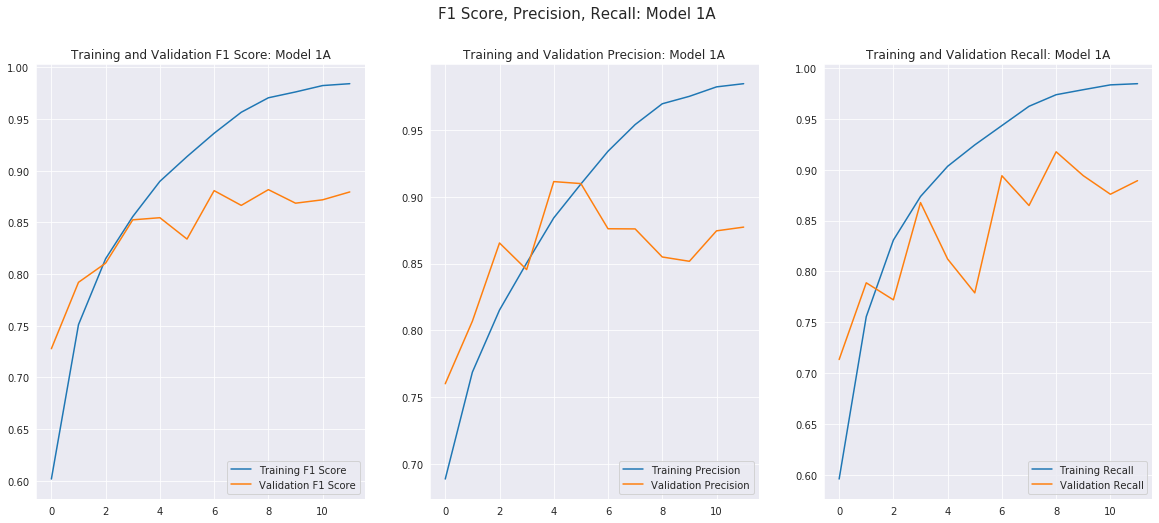

In [0]:
f1_1A = history_1A.history['f1_m']
val_f1_1A = history_1A.history['val_f1_m']

precision_1A = history_1A.history['precision_m']
val_precision_1A = history_1A.history['val_precision_m']

recall_1A = history_1A.history['recall_m']
val_recall_1A = history_1A.history['val_recall_m']


f,(ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(20, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)

ax1.plot(epochs_range, f1_1A, label='Training F1 Score')
ax1.plot(epochs_range, val_f1_1A, label='Validation F1 Score')
ax1.legend(loc='lower right')
ax1.title.set_text('Training and Validation F1 Score: Model 1A')

ax2.plot(epochs_range, precision_1A, label='Training Precision')
ax2.plot(epochs_range, val_precision_1A, label='Validation Precision')
ax2.legend(loc='lower right')
ax2.title.set_text('Training and Validation Precision: Model 1A')

ax3.plot(epochs_range, recall_1A, label='Training Recall')
ax3.plot(epochs_range, val_recall_1A, label='Validation Recall')
ax3.legend(loc='lower right')
ax3.title.set_text('Training and Validation Recall: Model 1A')

plt.suptitle('F1 Score, Precision, Recall: Model 1A', fontsize='15')

plt.show()

In [0]:
#Generate predictions from validation data from last checkpoint
val_data_gen.reset()
y_pred_1A = model_1A.predict_generator(val_data_gen, val_size // batch_size + 1)
y_pred_1A = np.round_(y_pred_1A)

In [0]:
#Get true labels
y_true = val_data_gen.classes[val_data_gen.index_array]
y_true_lab = list(val_data_gen.class_indices.keys())   

**Classification Reports**:
 - Classification reports do show signs that total accuracy, F1 score, precision, and recall can be improved, yet results seem to be adequate.
 - However, as loss shows significant increases over epochs, it is a clear sign that the model may not generalize well. As training progressed the validation showed that the model became more uncertain of the predictions that were made.

In [0]:
print('Classification Report: Model 1A \n', metrics.classification_report(y_true, y_pred_1A, target_names=y_true_lab))

Classification Report: Model 1A 
               precision    recall  f1-score   support

         cat       0.89      0.88      0.88      3148
         dog       0.88      0.89      0.88      3102

    accuracy                           0.88      6250
   macro avg       0.88      0.88      0.88      6250
weighted avg       0.88      0.88      0.88      6250



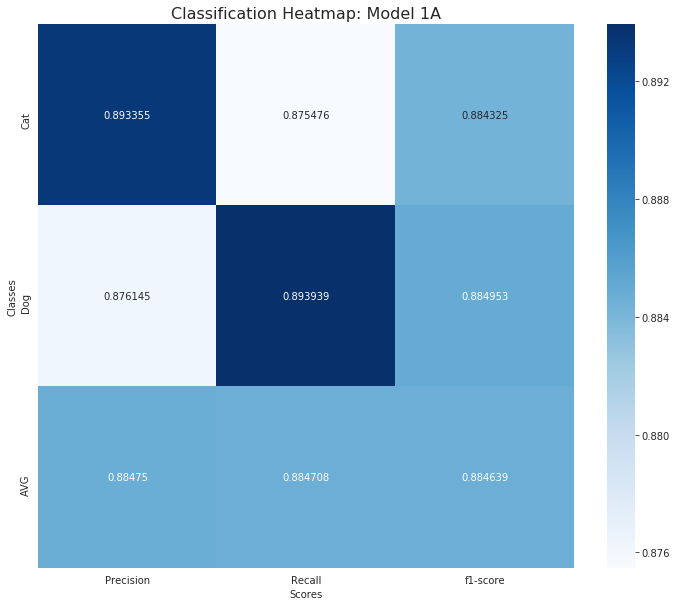

In [0]:
# Classification report heatmap
plot_classification_report(y_true, y_pred_1A, (12,10))
#plt.yticks('Cat', 'Dog')
plt.ylabel('Classes')
plt.xlabel('Scores')
plt.title('Classification Heatmap: Model 1A', fontsize='16')
plt.show();

**Confusion Matrix:**
 - Confusion matrix shows that 2756 cat images were correctly classified as not dogs, or the negative class. 392 were wrongly classified as dogs (false positives). 329 were wrongly classified as not dogs, or false negatives, and 2773 were correctly classified as dogs, or true positives.


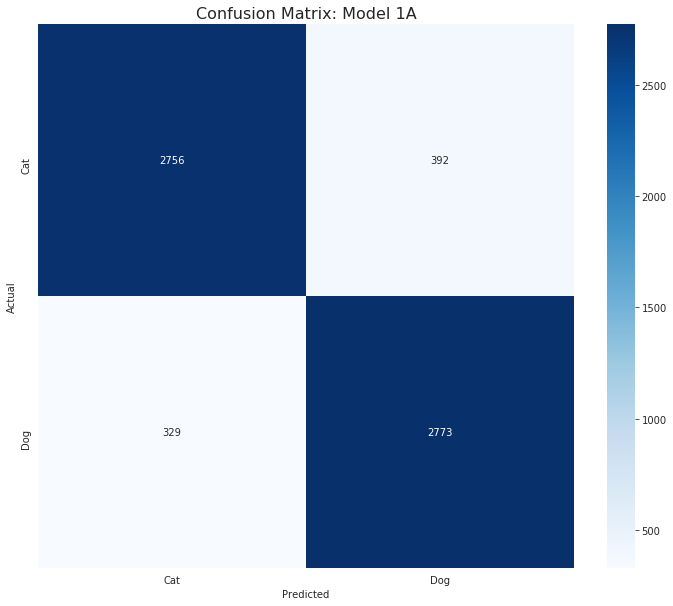

In [0]:
conf_mx1 = confusion_matrix(y_true, y_pred_1A)
plt.figure(figsize=(12,10))
plot_confusion_matrix(conf_mx1, True, None , 'Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix: Model 1A', fontsize='16')
plt.show();

**Run Model on Test Set:**

In [0]:
pred_1A = []
for i in fnames:
  img1 = image.load_img('./test_files/test_images/' + i, target_size=(IMG_HEIGHT, IMG_WIDTH))
  img = image.img_to_array(img1)/255
  img = np.expand_dims(img, axis=0)
  prediction = model_1A.predict(img, batch_size=None, steps=1)
  pred_1A.append(prediction)

In [0]:
sub_1A = []
for i in range(len(pred_1A)):
  sub_1A.append(pred_1A[i][0])

In [0]:
sub_1A_sub = pd.DataFrame(sub_1A, columns=['label'])

In [0]:
id=[]
fnames = os.listdir('test_files/test_images')
for i in range(len(fnames)):
  name = fnames[i].split('.')[0] 
  id.append(name) 

In [0]:
test_id = pd.DataFrame(id, columns=['id'])

In [0]:
sub_1A_sub_1A = pd.merge(test_id, sub_1A_sub, left_index=True, right_index=True)

In [0]:
sub_1A_sub_1A['id'] = sub_1A_sub_1A['id'].astype(int)

In [0]:
sub_1A_sub_1A.sort_values(by='id', inplace=True)

In [0]:
sub_1A_sub_1A.to_csv('submission_1A.csv', index=False)
from google.colab import files
files.download("submission_1A.csv")

**User Name: drew21717, User ID: 3311891, Kaggle Score: 0.31807**

In [0]:
#Store test result in variable
Test_1A = 0.31807

**Save Model:**

In [0]:
t = time.time()
export_path_model_1A = "./tmp/saved_models_1A.h5/{}".format(int(t))
model_1A.save(export_path_model_1A, save_format='tf')

export_path_model_1A

INFO:tensorflow:Assets written to: ./tmp/saved_models_1A.h5/1573392327/assets


'./tmp/saved_models_1A.h5/1573392327'

### **Model 1B:**
 - Batch normalization used after each convolutional layer, and for the fully connected layer.
 - Dropout of 0.25 is used after every max pooling layer and for the fully connected layer.
 - Five convolutional layers, five max pooling layers, one average pooling layer, and one fully connected layer along with the output layer. 
 - Nodes for convolutional layers are 3, 64, 128, and 512.
 - Fully connected layer has 512 nodes.
 - Early stopping set to 5 epochs where the least amount of loss is restored for testing.

In [0]:
# Clear session and define model parameters
tf.keras.backend.clear_session()

model_1B = Sequential([
    Conv2D(3, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05, center=True, scale=True, moving_variance_initializer='ones'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(64, 3, padding='same', activation='relu'),
    BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05, center=True, scale=True, moving_variance_initializer='ones'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(128, 3, padding='same', activation='relu'),
    BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05, center=True, scale=True, moving_variance_initializer='ones'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(256, 3, padding='same', activation='relu'),
    BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05, center=True, scale=True, moving_variance_initializer='ones'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(512, 3, padding='same', activation='relu'),
    BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05, center=True, scale=True, moving_variance_initializer='ones'),
    MaxPooling2D(),
    Dropout(0.25),
    AveragePooling2D(),
    Flatten(),
    BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05, center=True, scale=True, moving_variance_initializer='ones'),
    Dropout(0.25),
    Dense(512, activation='relu'),
    BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05, center=True, scale=True, moving_variance_initializer='ones'),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
])

In [0]:
#compile model and define optimizers
model_1B.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
#model summary
model_1B.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 3)       84        
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 3)       896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 3)       0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0

In [0]:
#Run model with execution time recorded
start = timer()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
history_1B = model_1B.fit_generator(
    train_data_gen,
    steps_per_epoch=train_size // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=val_size // batch_size,
    callbacks = [es]#, tbCallBack]
)
end = timer()
exec_time_model_1b = (end - start)/60

print('Total Processing Time in Minutes:', exec_time_model_1b)

Epoch 1/50
585/585 [==============================] - 97s 166ms/step - loss: 0.7177 - accuracy: 0.6228 - val_loss: 0.8260 - val_accuracy: 0.5776
Epoch 2/50
585/585 [==============================] - 84s 143ms/step - loss: 0.5289 - accuracy: 0.7326 - val_loss: 0.6325 - val_accuracy: 0.6742
Epoch 3/50
585/585 [==============================] - 84s 144ms/step - loss: 0.4412 - accuracy: 0.7935 - val_loss: 0.3953 - val_accuracy: 0.8244
Epoch 4/50
585/585 [==============================] - 84s 143ms/step - loss: 0.3831 - accuracy: 0.8278 - val_loss: 0.5758 - val_accuracy: 0.7612
Epoch 5/50
585/585 [==============================] - 83s 142ms/step - loss: 0.3450 - accuracy: 0.8478 - val_loss: 0.3668 - val_accuracy: 0.8439
Epoch 6/50
585/585 [==============================] - 83s 142ms/step - loss: 0.3119 - accuracy: 0.8643 - val_loss: 0.2898 - val_accuracy: 0.8804
Epoch 7/50
585/585 [==============================] - 83s 142ms/step - loss: 0.2702 - accuracy: 0.8852 - val_loss: 0.2650 - val_ac

In [0]:
tf.keras.backend.clear_session()

**Metrics and Visualizations:**

In [0]:
stats_train_1B = model_1B.evaluate(train_data_gen, verbose=1)
stats_val_1B = model_1B.evaluate(val_data_gen, verbose=1)  

196/196 [==============================] - 18s 94ms/step - loss: 0.1919 - accuracy: 0.9285


**Learning Curves:**
 - Learning curves below show signs that there is significantly less overfitting than before. 
 - Accuracy is much higher, and validation loss is more in line with training loss, where there overall gap is much narrow than the model that did not use regularization and batch normalization.

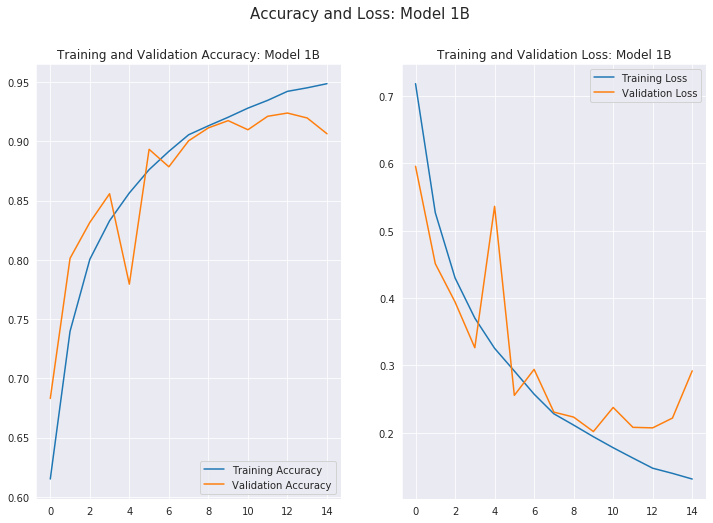

In [0]:
acc_1B = history_1B.history['accuracy']
val_acc_1B = history_1B.history['val_accuracy']

loss_1B = history_1B.history['loss']
val_loss_1B = history_1B.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_1B, label='Training Accuracy')
plt.plot(epochs_range, val_acc_1B, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy: Model 1B')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_1B, label='Training Loss')
plt.plot(epochs_range, val_loss_1B, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss: Model 1B')

plt.suptitle('Accuracy and Loss: Model 1B', fontsize='15')

plt.show()

**F1 Scores, Precision, and Recall:**
 - F1 scores, precision and recall show better improvements with regularization and batch normalization. The training and validation F1 scores over epochs show that the trade-offs between precision and recall are better in this model.
 - Although the plot shows that there is a significant drop in recall around the fourth epoch, there was significant recovery afterward. 

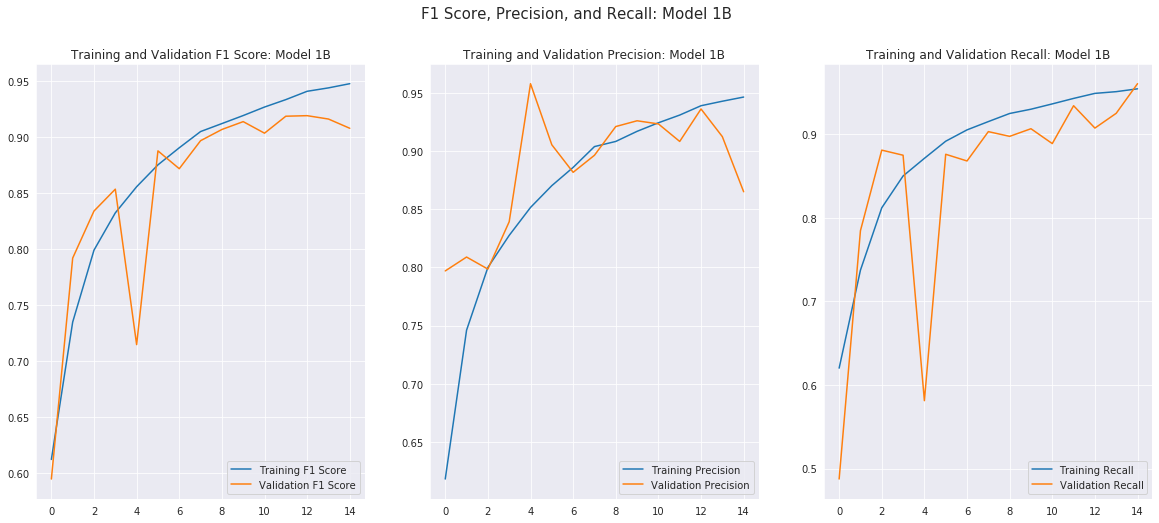

In [0]:
f1_1B = history_1B.history['f1_m']
val_f1_1B = history_1B.history['val_f1_m']

precision_1B = history_1B.history['precision_m']
val_precision_1B = history_1B.history['val_precision_m']

recall_1B = history_1B.history['recall_m']
val_recall_1B = history_1B.history['val_recall_m']


f,(ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(20, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)

ax1.plot(epochs_range, f1_1B, label='Training F1 Score')
ax1.plot(epochs_range, val_f1_1B, label='Validation F1 Score')
ax1.legend(loc='lower right')
ax1.title.set_text('Training and Validation F1 Score: Model 1B')

ax2.plot(epochs_range, precision_1B, label='Training Precision')
ax2.plot(epochs_range, val_precision_1B, label='Validation Precision')
ax2.legend(loc='lower right')
ax2.title.set_text('Training and Validation Precision: Model 1B')

ax3.plot(epochs_range, recall_1B, label='Training Recall')
ax3.plot(epochs_range, val_recall_1B, label='Validation Recall')
ax3.legend(loc='lower right')
ax3.title.set_text('Training and Validation Recall: Model 1B')

plt.suptitle('F1 Score, Precision, and Recall: Model 1B', fontsize='15')

plt.show()

In [0]:
val_data_gen.reset()
y_pred_1B = model_1B.predict_generator(val_data_gen, val_size // batch_size + 1)
y_pred_1B = np.round_(y_pred_1B)

In [0]:
y_true = val_data_gen.classes[val_data_gen.index_array]
y_true_lab = list(val_data_gen.class_indices.keys())   

**Classification Reports**:
 - Classification reports do show signs that total accuracy, F1 score, precision, and recall have significantly improved.
 - As loss shows significant decreases over epochs, it is a sign that the model may generalize well. As training progressed validation loss showed that the model became more certain of predictions.

In [0]:
print('Classification Report: Model 1B \n', metrics.classification_report(y_true, y_pred_1B, target_names=y_true_lab))

Classification Report: Model 1B 
               precision    recall  f1-score   support

         cat       0.91      0.93      0.92      3148
         dog       0.93      0.91      0.92      3102

    accuracy                           0.92      6250
   macro avg       0.92      0.92      0.92      6250
weighted avg       0.92      0.92      0.92      6250



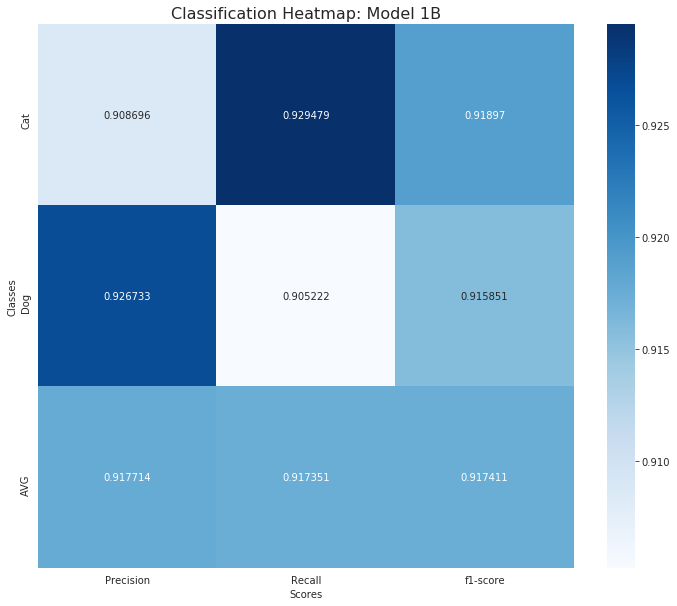

In [0]:
# Classification report heatmap
plot_classification_report(y_true, y_pred_1B, (12,10))
#plt.yticks('Cat', 'Dog')
plt.ylabel('Classes')
plt.xlabel('Scores')
plt.title('Classification Heatmap: Model 1B', fontsize='16')
plt.show();

**Confusion Matrix:**
 - Confusion matrix shows that 2926 cat images were correctly classified as not dogs, or the negative class. 222 were wrongly classified as dogs (false positives). 294 were wrongly classified as not dogs, or false negatives, and 2808 were correctly classified as dogs, or true positives.  
 - As F1 scores, precision, and recall were significantly improved in this model, the improvement is also apparent in the confusion matrix, as there are less false positives and false negatives.    

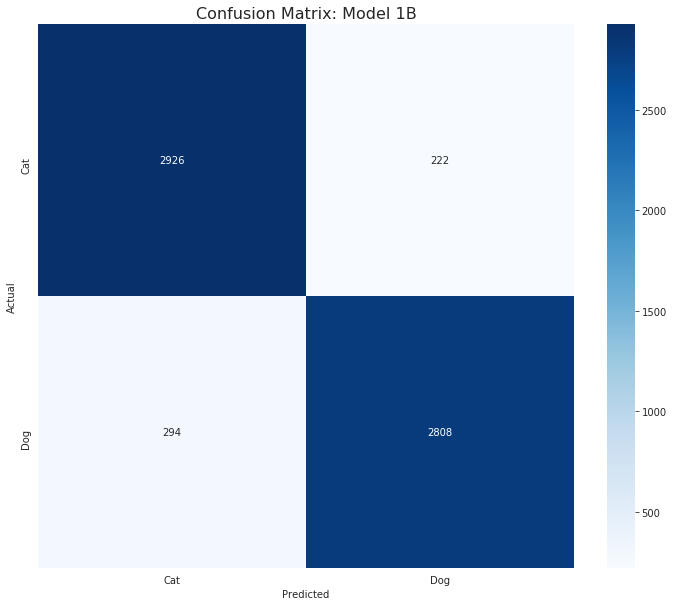

In [0]:
conf_mx2 = confusion_matrix(y_true, y_pred_1B)
plt.figure(figsize=(12,10))
plot_confusion_matrix(conf_mx2, True, None , 'Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix: Model 1B', fontsize='16')
plt.show();

**Run Model on Test Set:**

In [0]:
pred_1B = []
for i in fnames:
  img1 = image.load_img('./test_files/test_images/' + i, target_size=(IMG_HEIGHT, IMG_WIDTH))
  img = image.img_to_array(img1)/255
  img = np.expand_dims(img, axis=0)
  prediction = model_1B.predict(img, batch_size=None, steps=1)
  pred_1B.append(prediction)

In [0]:
len(pred_1B)

12500

In [0]:
sub_1B = []
for i in range(len(pred_1B)):
  sub_1B.append(pred_1B[i][0])

In [0]:
len(sub_1B)

12500

In [0]:
sub_1B_sub = pd.DataFrame(sub_1B, columns=['label'])

In [0]:
id=[]
fnames = os.listdir('test_files/test_images')
for i in range(len(fnames)):
  name = fnames[i].split('.')[0] 
  id.append(name) 

In [0]:
test_id = pd.DataFrame(id, columns=['id'])

In [0]:
sub_1B_sub_1B = pd.merge(test_id, sub_1B_sub, left_index=True, right_index=True)

In [0]:
sub_1B_sub_1B['id'] = sub_1B_sub_1B['id'].astype(int)

In [0]:
sub_1B_sub_1B.sort_values(by='id', inplace=True)

In [0]:
sub_1B_sub_1B.to_csv('submission_1B.csv', index=False)
from google.colab import files
files.download("submission_1B.csv")

**User Name: drew21717, User ID: 3311891, Kaggle Score: 0.24161**

In [0]:
#Store test result in variable
Test_1B = 0.24161

**Save Model:**

In [0]:
t = time.time()
export_path_model_1B = "/tmp/saved_models_1B.h5/{}".format(int(t))
model_1B.save(export_path_model_1B, save_format='tf')

export_path_model_1B

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/saved_models_1B.h5/1573390385/assets


'/tmp/saved_models_1B.h5/1573390385'

## **Experimental Factor 2:**
 - Each model in the following experimental factor used a different mix of layers and nodes that were inspired by the VGG16 architecture.
 - As loss began to rise where model training had to be stopped through early stopping in experimental factor 1, it seemed that this may have been due to overfitting. Therefore, data was augmented in experimental factor 2.
 - The first model used a scaled down version of VGG16 with less layers and less nodes. 
 - The second model also used a modified version of VGG16, yet with almost the same amount of layers. The amount of nodes were different, as well as the usage of dropouts and batch normalization. Dropouts were used after every max pooling layer and for the two fully connected layers. 
 -Early stopping was used for both models that were set to the least amount of loss. Models were ran over 50 epochs with a batch size of 32, with 585 steps per epoch for training, and 195 steps for validation.
 - The first model did not do well, as the model could not converge to an optimal solution. This was likely due to a vanishing gradients problem. Vanishing gradients are usually resolvable through batch normalization. A vanishing gradients problem occurs when parameters are updated through backpropagation, and gradients get small enough to the point where the Gradient Descent update leaves the lower connection weights virtually unchanged, and training never converges to a good solution [1].  
 - Therefore, in the second model, batch normalization and regularization using dropout were heavily used, and the model was able to converge to an optimal solution. Although the optimal solution could have been better with more training over epochs, the results were indeed adequate.  

### **Data Augmentation**:
Overfitting generally occurs when there are a small number of training examples. One way to approach this problem is to augment the dataset so that it has a sufficient number of training examples. Data augmentation involves generating more training data from existing training samples by augmenting the samples using random transformations that yield more images. This helps the model by adding more aspects of the data to generalize better [3]. In experimental factor two, data augmentation was used, where augmentations were passed randomly throughout the dataset.

**Training Images with Horizontal Flip:**

In [0]:
image_generator = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [0]:
train_data_gen = image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory='./train_train',
                                                           shuffle=True,
                                                           color_mode='rgb',
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary',
                                                           seed=42)


Found 18750 images belonging to 2 classes.


In [0]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

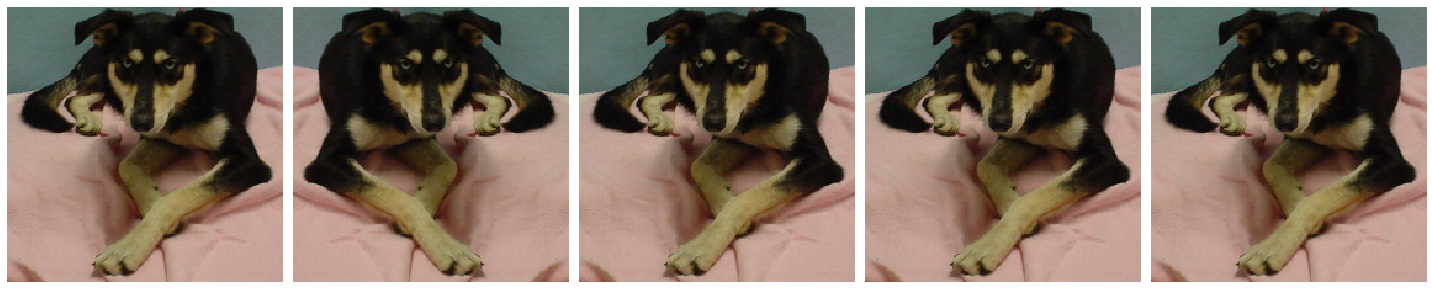

In [0]:
# Re-use the same custom plotting function defined and used
# above to visualize the training images
plotImages(augmented_images)

**Training Images with 45 Degree Rotation:**

In [0]:
image_generator = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [0]:
train_data_gen = image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory='./train_train',
                                                           shuffle=True,
                                                           color_mode='rgb',
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary',
                                                           seed=42)
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 18750 images belonging to 2 classes.


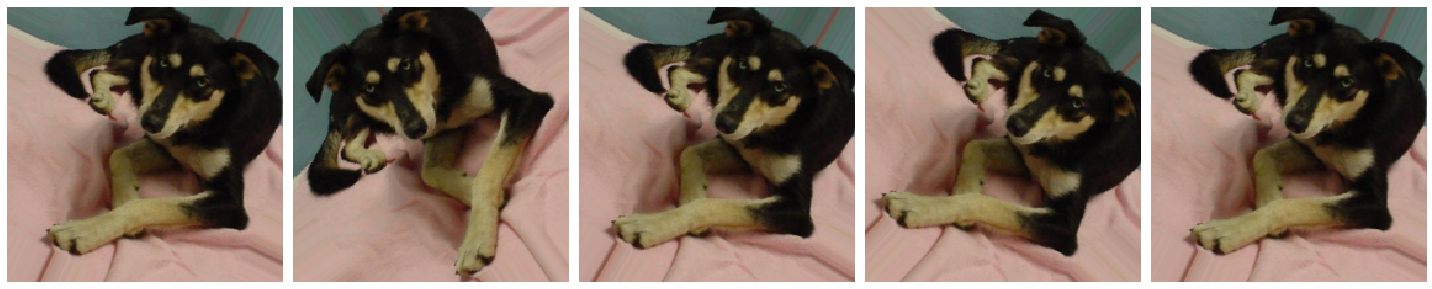

In [0]:
plotImages(augmented_images)

**Training Images with Zoom:**

In [0]:
image_generator = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

In [0]:
train_data_gen = image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory='./train_train',
                                                           shuffle=True,
                                                           color_mode='rgb',
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary',
                                                           seed=42)
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 18750 images belonging to 2 classes.


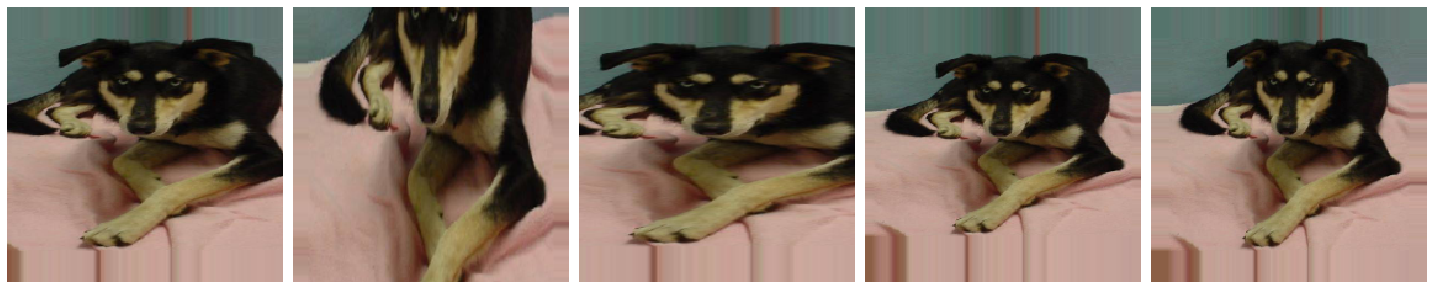

In [0]:
plotImages(augmented_images)

**Training Images Prepared with All Augmentations:**

In [0]:
train_data_gen.reset()
train_image_generator = ImageDataGenerator(rescale=1./255,
                                           rotation_range=45,
                                           width_shift_range=.15,
                                           height_shift_range=.15,
                                           horizontal_flip=True,
                                           zoom_range=0.5
                                           )

In [0]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory='./train_train',
                                                           shuffle=True,
                                                           color_mode='rgb',
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary',
                                                           seed=42)

Found 18750 images belonging to 2 classes.


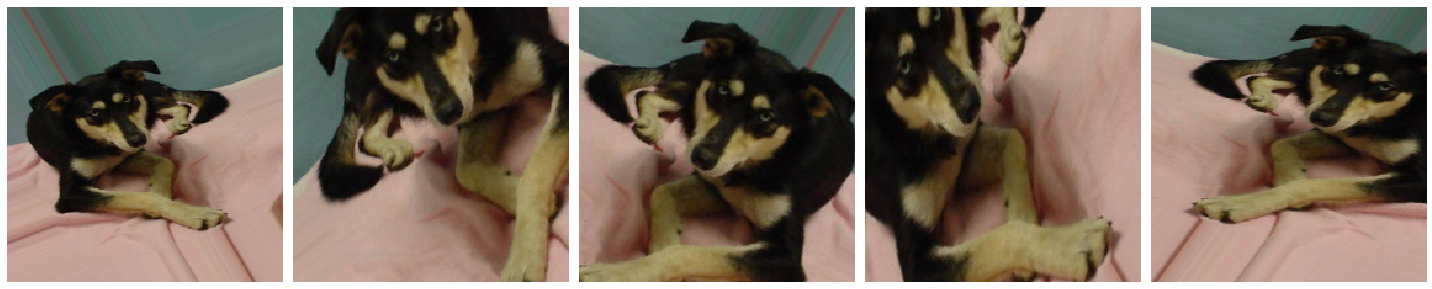

In [0]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [0]:
val_data_gen.reset()
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [0]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory='./train_valid',
                                                              shuffle=True,
                                                              color_mode='rgb',
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary',
                                                              seed=42
                                                              )

Found 6250 images belonging to 2 classes.


### **Model 2A:**
 - Model is inspired from the VGG16 architecture.
 - No normalization is applied.
 - 0.5 dropout is applied for the two fully connected layers.
 - Due to number of images and time and resources, the number of convolutional filters are cut in half, and fully connected layers are scaled down from the 4096 nodes used in VGG16 to 256 nodes.
 - Early stopping is used where the model is stopped after 5 epochs if there are no signs of improvement. 

In [0]:
tf.keras.backend.clear_session()

model_2A = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D((2,2), strides=(2,2)),
    Conv2D(64, 3, padding='same', activation='relu'),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D((2,2), strides=(2,2)),
    Conv2D(128, 3, padding='same', activation='relu'),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D((2,2), strides=(2,2)),
    Conv2D(256, 3, padding='same', activation='relu'),
    Conv2D(256, 3, padding='same', activation='relu'),
    MaxPooling2D((2,2), strides=(2,2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [0]:
model_2A.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',f1_m, precision_m, recall_m])

In [0]:
model_2A.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 128)       7

In [0]:
start = timer()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

history_2A = model_2A.fit_generator(
    train_data_gen,
    steps_per_epoch=train_size // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=val_size // batch_size,
    callbacks = [es, tbCallBack]
)
end = timer()
exec_time_model_2a = (end - start)/60

print('Total Processing Time in Minutes:', exec_time_model_2a)

Epoch 1/50
585/585 [==============================] - 215s 367ms/step - loss: 0.6935 - accuracy: 0.4923 - f1_m: 0.4108 - precision_m: 0.4503 - recall_m: 0.4924 - val_loss: 0.6932 - val_accuracy: 0.4960 - val_f1_m: 0.6573 - val_precision_m: 0.4960 - val_recall_m: 1.0000
Epoch 2/50
585/585 [==============================] - 214s 366ms/step - loss: 0.6933 - accuracy: 0.4974 - f1_m: 0.4293 - precision_m: 0.4742 - recall_m: 0.5051 - val_loss: 0.6935 - val_accuracy: 0.4960 - val_f1_m: 0.6573 - val_precision_m: 0.4960 - val_recall_m: 1.0000
Epoch 3/50
585/585 [==============================] - 215s 367ms/step - loss: 0.6932 - accuracy: 0.4998 - f1_m: 0.5353 - precision_m: 0.5038 - recall_m: 0.6410 - val_loss: 0.6932 - val_accuracy: 0.4960 - val_f1_m: 0.6573 - val_precision_m: 0.4960 - val_recall_m: 1.0000
Epoch 4/50
585/585 [==============================] - 214s 366ms/step - loss: 0.6933 - accuracy: 0.4999 - f1_m: 0.5484 - precision_m: 0.5055 - recall_m: 0.6906 - val_loss: 0.6931 - val_accur

In [0]:
tf.keras.backend.clear_session()

**Metrics and Visualizations:**

In [0]:
stats_train_2A = model_2A.evaluate(train_data_gen, verbose=1)
stats_val_2A = model_2A.evaluate(val_data_gen, verbose=1)  

196/196 [==============================] - 21s 106ms/step - loss: 0.6931 - accuracy: 0.5037 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00


**Learning Curves:**
 - Learning curves below show that accuracy and loss curves are close, yet the high loss shows that the model may be underfitting. 
 - This is in stark contrast to the models in experimental factor 1.
 - The poor performance of the model may be due to a vanishing gradients problem as training never converged to a good solution.

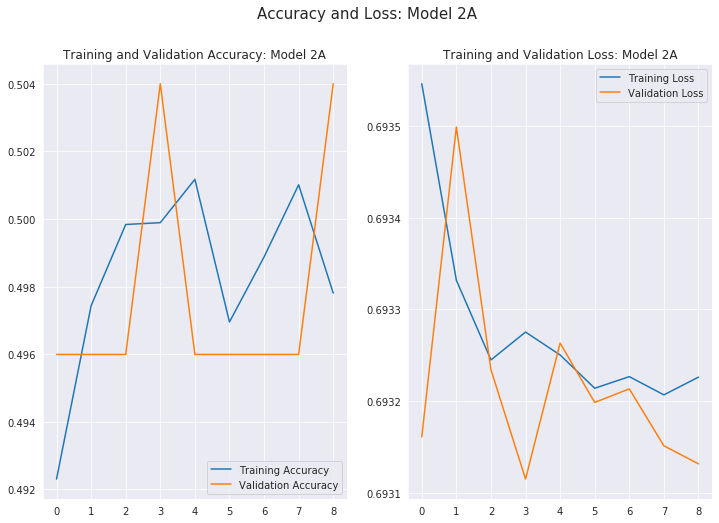

In [0]:
acc_2A = history_2A.history['accuracy']
val_acc_2A = history_2A.history['val_accuracy']

loss_2A = history_2A.history['loss']
val_loss_2A = history_2A.history['val_loss']

epochs_range = range(9)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_2A, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2A, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy: Model 2A')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_2A, label='Training Loss')
plt.plot(epochs_range, val_loss_2A, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss: Model 2A')

plt.suptitle('Accuracy and Loss: Model 2A', fontsize='15')

plt.show()

**F1 Scores, Precision, and Recall:**
 - F1 scores, precision and recall shows that the model struggled to learn in training. Validation recall was consistently at 1.0 while precision maintained a score of 0.5. This negatively affected the F1 score.   

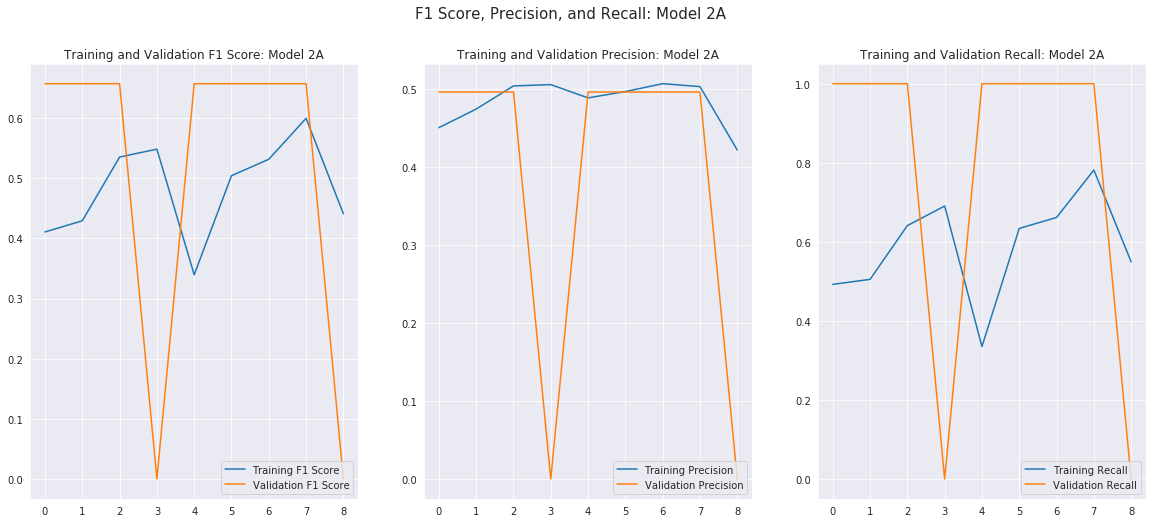

In [0]:
f1_2A = history_2A.history['f1_m']
val_f1_2A = history_2A.history['val_f1_m']

precision_2A = history_2A.history['precision_m']
val_precision_2A = history_2A.history['val_precision_m']

recall_2A = history_2A.history['recall_m']
val_recall_2A = history_2A.history['val_recall_m']


f,(ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(20, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)

ax1.plot(epochs_range, f1_2A, label='Training F1 Score')
ax1.plot(epochs_range, val_f1_2A, label='Validation F1 Score')
ax1.legend(loc='lower right')
ax1.title.set_text('Training and Validation F1 Score: Model 2A')

ax2.plot(epochs_range, precision_2A, label='Training Precision')
ax2.plot(epochs_range, val_precision_2A, label='Validation Precision')
ax2.legend(loc='lower right')
ax2.title.set_text('Training and Validation Precision: Model 2A')

ax3.plot(epochs_range, recall_2A, label='Training Recall')
ax3.plot(epochs_range, val_recall_2A, label='Validation Recall')
ax3.legend(loc='lower right')
ax3.title.set_text('Training and Validation Recall: Model 2A')

plt.suptitle('F1 Score, Precision, and Recall: Model 2A', fontsize='15')

plt.show()

In [0]:
val_data_gen.reset()
y_pred_2A = model_2A.predict_generator(val_data_gen, val_size // batch_size + 1)
y_pred_2A = np.round_(y_pred_2A)

In [0]:
y_true = val_data_gen.classes[val_data_gen.index_array]
y_true_lab = list(val_data_gen.class_indices.keys())   

**Classification Reports**:
 - Classification reports show signs that total accuracy, F1 score, precision, and recall need significant improvement. At 100% recall it detects 50% of cats while the model had 0 precision, recall, and F1 scores on dogs. This is an indication of the model's uncertainty of making predictions.  

In [0]:
print('Classification Report: Model 2A \n', metrics.classification_report(y_true, y_pred_2A, target_names=y_true_lab))

Classification Report: Model 2A 
               precision    recall  f1-score   support

         cat       0.50      1.00      0.67      3148
         dog       0.00      0.00      0.00      3102

    accuracy                           0.50      6250
   macro avg       0.25      0.50      0.33      6250
weighted avg       0.25      0.50      0.34      6250



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


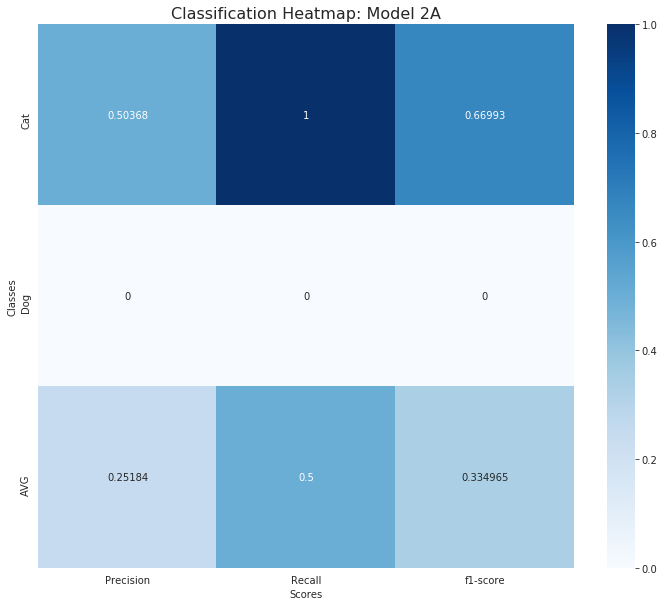

In [0]:
# Classification report heatmap
plot_classification_report(y_true, y_pred_2A, (12,10))
plt.ylabel('Classes')
plt.xlabel('Scores')
plt.title('Classification Heatmap: Model 2A', fontsize='16')
plt.show();

**Confusion Matrix:**
 - The confusion matrix is unreliable and cannot be used for interpretation.

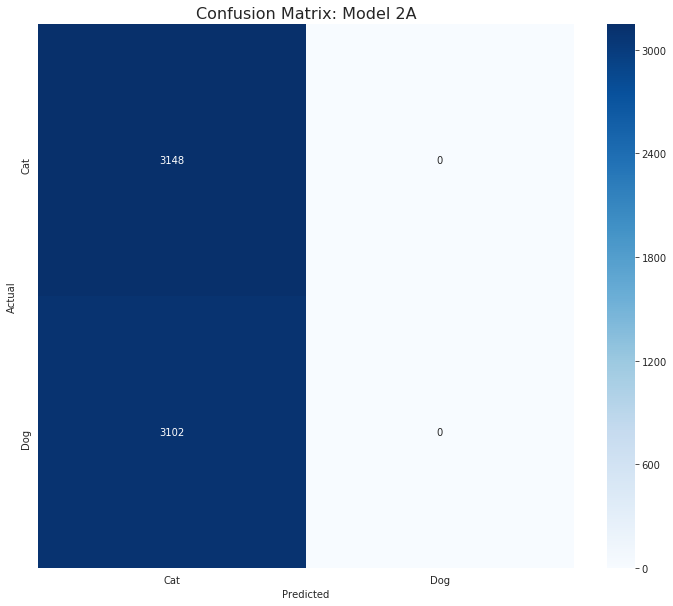

In [0]:
conf_mx3 = confusion_matrix(y_true, y_pred_2A)
plt.figure(figsize=(12,10))
plot_confusion_matrix(conf_mx3, True, None , 'Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix: Model 2A', fontsize='16')
plt.show();

**Run Model on Test Set:**

In [0]:
pred_2A = []
for i in fnames:
  img1 = image.load_img('./test_files/test_images/' + i, target_size=(IMG_HEIGHT, IMG_WIDTH))
  img = image.img_to_array(img1)/255
  img = np.expand_dims(img, axis=0)
  prediction = model_2A.predict(img, batch_size=None, steps=1)
  pred_2A.append(prediction)

In [0]:
len(pred_2A)

12500

In [0]:
sub_2A = []
for i in range(len(pred_1B)):
  sub_2A.append(pred_2A[i][0])

In [0]:
len(sub_2A)

12500

In [0]:
sub_2A_sub = pd.DataFrame(sub_2A, columns=['label'])

In [0]:
id=[]
fnames = os.listdir('test_files/test_images')
for i in range(len(fnames)):
  name = fnames[i].split('.')[0] 
  id.append(name) 

In [0]:
test_id = pd.DataFrame(id, columns=['id'])

In [0]:
sub_2A_sub_2A = pd.merge(test_id, sub_2A_sub, left_index=True, right_index=True)

In [0]:
sub_2A_sub_2A['id'] = sub_2A_sub_2A['id'].astype(int)

In [0]:
sub_2A_sub_2A.sort_values(by='id', inplace=True)

In [0]:
sub_2A_sub_2A.to_csv('submission_2A.csv', index=False)
from google.colab import files
files.download("submission_2A.csv")

**User Name: drew21717, User ID: 3311891, Kaggle Score: 0.69318**

In [0]:
#Store test result in variable
Test_2A = 0.69318

**Save Model:**

In [0]:
t = time.time()
export_path_model_2A = "/tmp/saved_models_2A.h5/{}".format(int(t))
model_1B.save(export_path_model_1B, save_format='tf')

export_path_model_2A

INFO:tensorflow:Assets written to: /tmp/saved_models_1B.h5/1573390385/assets


'/tmp/saved_models_2A.h5/1573397443'

### **Model 2B:**
 - While this model is different than model 2A, it is still a modified version of the VGG16 architecture.
 - 0.25 dropouts are applied after every max pooling layer, the 2 fully connected layers with 1024 nodes and 512 nodes have a dropout of 0.25 and and 0.5, respectively.
 - Though there are different numbers of nodes, the amount of layers are almost the same as what is used in the VGG16 architecture.
 - However, there are many dropouts that are applied, and every convolutional layer and fully connected layer is batch normalized.
 - There are 13 convolutional layers, 5 max pooling layers, 2 fully connected layers, and one global average pooling layer (similar to adaptive pooling).
 - There is zero padding for convolutional layers, max pooling layers use a 2 x 2 kernel and a stride of 2.
 - All layers use ReLu activation except for the output layer, which uses sigmoid.  

In [0]:
tf.keras.backend.clear_session()

model_2B = Sequential([
    Conv2D(3, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05, center=True, scale=True, moving_variance_initializer='ones'),
    Conv2D(64, 3, padding='same', activation='relu'),
    BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05, center=True, scale=True, moving_variance_initializer='ones'),
    MaxPooling2D((2,2), strides=(2,2)),
    Dropout(0.25),
    Conv2D(64, 3, padding='same', activation='relu'),
    BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05, center=True, scale=True, moving_variance_initializer='ones'),
    Conv2D(128, 3, padding='same', activation='relu'),
    BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05, center=True, scale=True, moving_variance_initializer='ones'),
    MaxPooling2D((2,2), strides=(2,2)),
    Dropout(0.25),
    Conv2D(128, 3, padding='same', activation='relu'),
    BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05, center=True, scale=True, moving_variance_initializer='ones'),
    Conv2D(256, 3, padding='same', activation='relu'),
    BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05, center=True, scale=True, moving_variance_initializer='ones'),
    Conv2D(256, 3, padding='same', activation='relu'),
    BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05, center=True, scale=True, moving_variance_initializer='ones'),
    MaxPooling2D((2,2), strides=(2,2)),
    Dropout(0.25),
    Conv2D(256, 3, padding='same', activation='relu'),
    BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05, center=True, scale=True, moving_variance_initializer='ones'),
    Conv2D(512, 3, padding='same', activation='relu'),
    BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05, center=True, scale=True, moving_variance_initializer='ones'),
    Conv2D(512, 3, padding='same', activation='relu'),
    BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05, center=True, scale=True, moving_variance_initializer='ones'),
    MaxPooling2D((2,2), strides=(2,2)),
    Dropout(0.25),
    Conv2D(512, 3, padding='same', activation='relu'),
    BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05, center=True, scale=True, moving_variance_initializer='ones'),
    Conv2D(512, 3, padding='same', activation='relu'),
    BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05, center=True, scale=True, moving_variance_initializer='ones'),
    Conv2D(512, 3, padding='same', activation='relu'),
    BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05, center=True, scale=True, moving_variance_initializer='ones'),
    MaxPooling2D((2,2), strides=(2,2)),
    Dropout(0.25),
    GlobalAveragePooling2D(),
    Flatten(),
    BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05, center=True, scale=True, moving_variance_initializer='ones'),
    Dense(1024, activation='relu'),
    Dropout(0.25),
    BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05, center=True, scale=True, moving_variance_initializer='ones'),
    Dense(512, activation='relu'),
    Dropout(0.5),
    BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05, center=True, scale=True, moving_variance_initializer='ones'),
    Dense(1, activation='sigmoid')
])

In [0]:
model_2B.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',f1_m, precision_m, recall_m])

In [0]:
model_2B.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 3)       84        
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 3)       896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      3

In [0]:
start = timer()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8, restore_best_weights=True)

history_2B = model_2B.fit_generator(
    train_data_gen,
    steps_per_epoch=train_size // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=val_size // batch_size,
    callbacks = [es, tbCallBack]
)
end = timer()
exec_time_model_2b = (end - start)/60

print('Total Processing Time in Minutes:', exec_time_model_2b)

Epoch 1/50
585/585 [==============================] - 254s 433ms/step - loss: 0.7624 - accuracy: 0.5237 - f1_m: 0.5198 - precision_m: 0.5254 - recall_m: 0.5272 - val_loss: 0.6767 - val_accuracy: 0.5538 - val_f1_m: 0.6097 - val_precision_m: 0.5374 - val_recall_m: 0.7260
Epoch 2/50
585/585 [==============================] - 254s 433ms/step - loss: 0.7041 - accuracy: 0.5398 - f1_m: 0.5344 - precision_m: 0.5417 - recall_m: 0.5404 - val_loss: 0.6772 - val_accuracy: 0.5774 - val_f1_m: 0.5434 - val_precision_m: 0.5839 - val_recall_m: 0.5262
Epoch 3/50
585/585 [==============================] - 253s 432ms/step - loss: 0.6839 - accuracy: 0.5666 - f1_m: 0.5574 - precision_m: 0.5704 - recall_m: 0.5577 - val_loss: 0.6826 - val_accuracy: 0.5849 - val_f1_m: 0.6318 - val_precision_m: 0.5619 - val_recall_m: 0.7433
Epoch 4/50
585/585 [==============================] - 255s 435ms/step - loss: 0.6742 - accuracy: 0.5894 - f1_m: 0.5850 - precision_m: 0.5937 - recall_m: 0.5915 - val_loss: 0.6656 - val_accur

In [0]:
tf.keras.backend.clear_session()

**Metrics and Visualizations:**

In [0]:
stats_train_2B = model_2B.evaluate(train_data_gen, verbose=1)
stats_val_2B = model_2B.evaluate(val_data_gen, verbose=1)  

196/196 [==============================] - 28s 142ms/step - loss: 0.1200 - accuracy: 0.9525 - f1_m: 0.9506 - precision_m: 0.9650 - recall_m: 0.9397


**Learning Curves:**
 - Learning curves below show better signs of fitting, indicating that the model would generalize well to new data.
 - As epochs increase accuracy and loss only get better. It is presumable that accuracy and loss would show more improvement if more epochs were set in training the model.
 - Model 2B was the only model where it was not cutoff through early stopping. All other models showed increases in loss and decreases in accuracy as they were stopped.

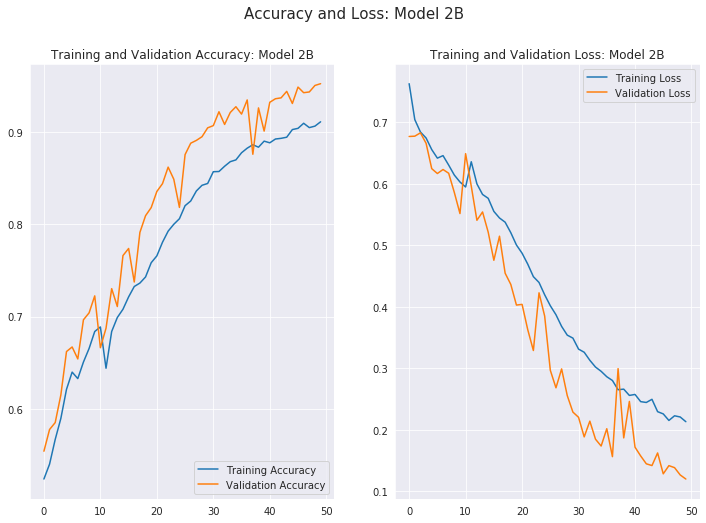

In [0]:
acc_2B = history_2B.history['accuracy']
val_acc_2B = history_2B.history['val_accuracy']

loss_2B = history_2B.history['loss']
val_loss_2B = history_2B.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_2B, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2B, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy: Model 2B')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_2B, label='Training Loss')
plt.plot(epochs_range, val_loss_2B, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss: Model 2B')

plt.suptitle('Accuracy and Loss: Model 2B', fontsize='15')

plt.show()

**F1 Scores, Precision, and Recall:**
 - F1 scores, precision, and recall show better improvements using an architecture similar to VGG16 with regularization and batch normalization.  The training and validation F1 scores over epochs show that the trade-offs between precision and recall are better in this model overall.

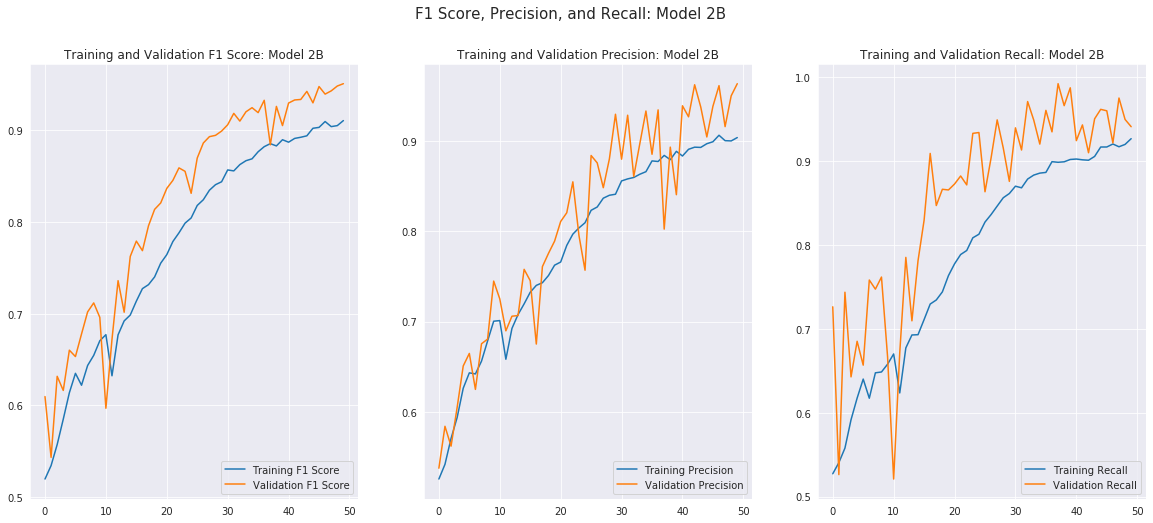

In [0]:
f1_2B = history_2B.history['f1_m']
val_f1_2B = history_2B.history['val_f1_m']

precision_2B = history_2B.history['precision_m']
val_precision_2B = history_2B.history['val_precision_m']

recall_2B = history_2B.history['recall_m']
val_recall_2B = history_2B.history['val_recall_m']


f,(ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(20, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)

ax1.plot(epochs_range, f1_2B, label='Training F1 Score')
ax1.plot(epochs_range, val_f1_2B, label='Validation F1 Score')
ax1.legend(loc='lower right')
ax1.title.set_text('Training and Validation F1 Score: Model 2B')

ax2.plot(epochs_range, precision_2B, label='Training Precision')
ax2.plot(epochs_range, val_precision_2B, label='Validation Precision')
ax2.legend(loc='lower right')
ax2.title.set_text('Training and Validation Precision: Model 2B')

ax3.plot(epochs_range, recall_2B, label='Training Recall')
ax3.plot(epochs_range, val_recall_2B, label='Validation Recall')
ax3.legend(loc='lower right')
ax3.title.set_text('Training and Validation Recall: Model 2B')

plt.suptitle('F1 Score, Precision, and Recall: Model 2B', fontsize='15')

plt.show()

In [0]:
val_data_gen.reset()
y_pred_2B = model_2B.predict_generator(val_data_gen, val_size // batch_size + 1)
y_pred_2B = np.round_(y_pred_2B)

In [0]:
y_true = val_data_gen.classes[val_data_gen.index_array]
y_true_lab = list(val_data_gen.class_indices.keys())   

**Classification Reports**:

 - Classification reports further confirm that total accuracy, F1 score, precision, and recall were better in this model than all the others.
 - As loss showed significant decreases over epochs all the way to the end, it is a very good sign that the model would generalize better than the other models. As training progressed towards the end, validation loss showed that the model became more and more certain of predictions.


In [0]:
print('Classification Report: Model 2B \n', metrics.classification_report(y_true, y_pred_2B, target_names=y_true_lab))

Classification Report: Model 2B 
               precision    recall  f1-score   support

         cat       0.94      0.97      0.95      3148
         dog       0.96      0.94      0.95      3102

    accuracy                           0.95      6250
   macro avg       0.95      0.95      0.95      6250
weighted avg       0.95      0.95      0.95      6250



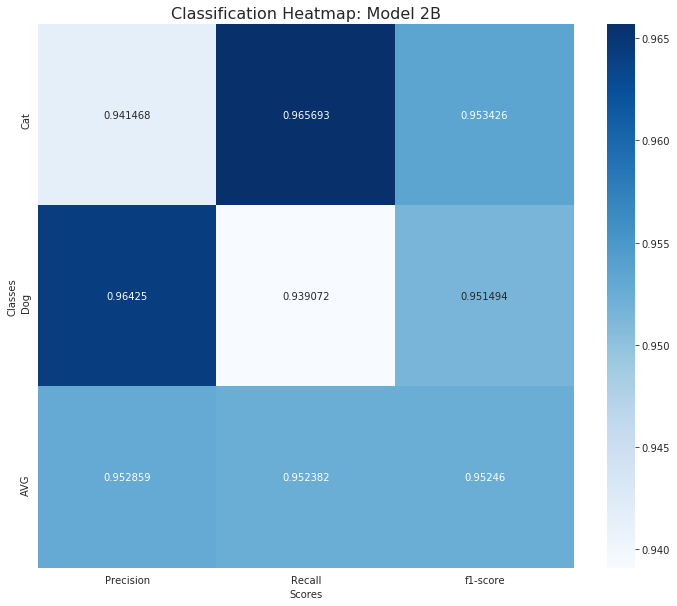

In [0]:
# Classification report heatmap
plot_classification_report(y_true, y_pred_2B, (12,10))
#plt.yticks('Cat', 'Dog')
plt.ylabel('Classes')
plt.xlabel('Scores')
plt.title('Classification Heatmap: Model 2B', fontsize='16')
plt.show();

**Confusion Matrix:**
 - Confusion matrix shows that 3040 cat images were correctly classified as not dogs, or the negative class. 108 were wrongly classified as dogs (false positives). 189 were wrongly classified as not dogs, or false negatives, and 2913 were correctly classified as dogs, or true positives. 
 - Out of all of the models in this experiment, this model using an architecture similar to VGG16 with batch normalization and dropout, had the least false positives and false negatives, which are also supported by the F1 scores, precision, and recall.  

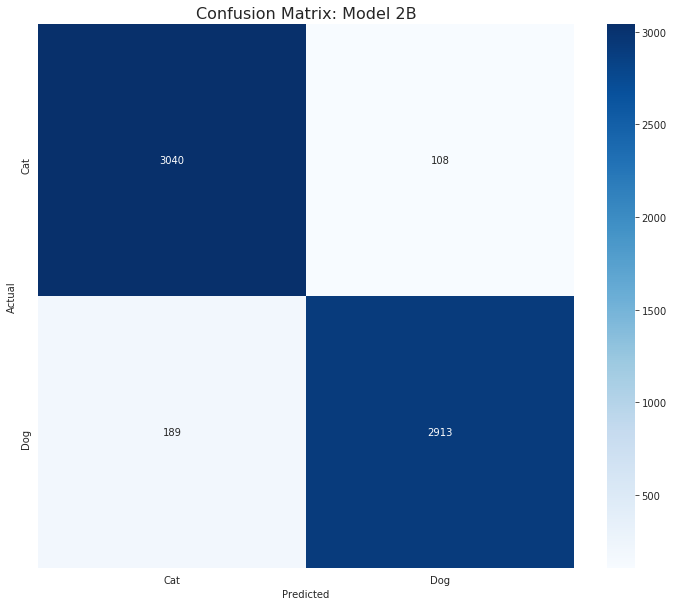

In [0]:
conf_mx4 = confusion_matrix(y_true, y_pred_2B)
plt.figure(figsize=(12,10))
plot_confusion_matrix(conf_mx4, True, None , 'Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix: Model 2B', fontsize='16')
plt.show();

**Run Model on Test Set:**

In [0]:
pred_2B = []
for i in fnames:
  img1 = image.load_img('./test_files/test_images/' + i, target_size=(IMG_HEIGHT, IMG_WIDTH))
  img = image.img_to_array(img1)/255
  img = np.expand_dims(img, axis=0)
  prediction = model_2B.predict(img, batch_size=None, steps=1)
  pred_2B.append(prediction)

In [0]:
len(pred_2B)

12500

In [0]:
sub_2B = []
for i in range(len(pred_1B)):
  sub_2B.append(pred_2B[i][0])

In [0]:
len(sub_2B)

12500

In [0]:
sub_2B_sub = pd.DataFrame(sub_2B, columns=['label'])

In [0]:
id=[]
fnames = os.listdir('test_files/test_images')
for i in range(len(fnames)):
  name = fnames[i].split('.')[0] 
  id.append(name) 

In [0]:
test_id = pd.DataFrame(id, columns=['id'])

In [0]:
sub_2B_sub_2B = pd.merge(test_id, sub_2B_sub, left_index=True, right_index=True)

In [0]:
sub_2B_sub_2B['id'] = sub_2B_sub_2B['id'].astype(int)

In [0]:
sub_2B_sub_2B.sort_values(by='id', inplace=True)

In [0]:
sub_2B_sub_2B.to_csv('submission_2B.csv', index=False)
from google.colab import files
files.download("submission_2B.csv")

**User Name: drew21717, User ID: 3311891, Kaggle Score: 0.16971**

In [0]:
#Store test result in variable
Test_2B = 0.16971

**Save Model:**

In [0]:
t = time.time()
export_path_model_2B = "/tmp/saved_models_2B.h5/{}".format(int(t))
model_1B.save(export_path_model_1B, save_format='tf')

export_path_model_2B

INFO:tensorflow:Assets written to: /tmp/saved_models_1B.h5/1573390385/assets


'/tmp/saved_models_2B.h5/1573414185'

### **Comparison of Models:**

**Accuracy Comparison of Models:**
 - Accuracy scores over epochs show that models 1B and 2B of experimental factors were significantly better than their counterparts.
 - This is likely due to the application of batch normalization and regularization through using dropouts.
 - However, model 1B shows a decrease after the 13th epoch, and if it had not been stopped through early stopping, it is presumable that accuracy would have continued to fall. This is also supported by examining loss, as it began to increase after the 13th epoch.
 - Although model 2B stopped training after the 50th epoch, this was not due to early stopping. It is assumed that this would have continued to increase. Due to lack of time and computing resources, this could not be further explored.
 - The flat line of model 2A exemplifies that the model had difficulty in converging to an optimal solution. It was not able to train over the data properly, which was a sign of a vanishing gradients problem.


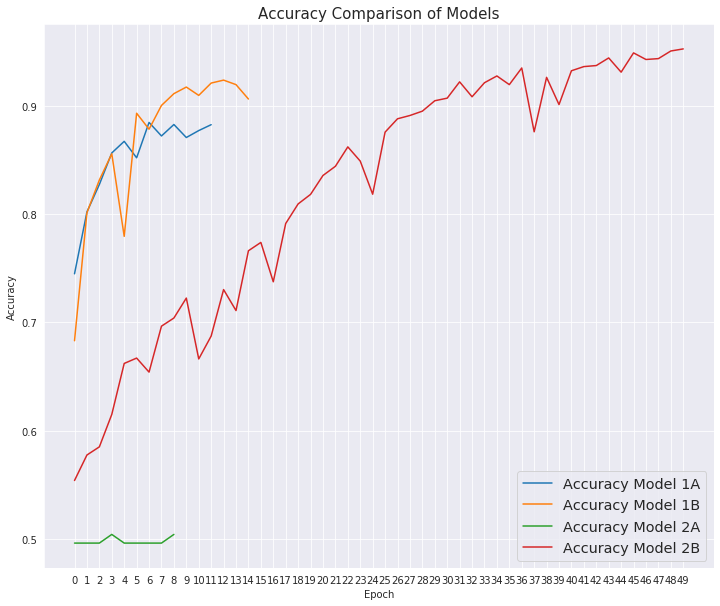

In [0]:
#Plot validation accuracy for all models
fig, ax = plt.subplots(figsize=(12,10))
ax.plot(val_acc_1A, label='Accuracy Model 1A')
ax.plot(val_acc_1B, label='Accuracy Model 1B')
ax.plot(val_acc_2A, label='Accuracy Model 2A')
ax.plot(val_acc_2B, label='Accuracy Model 2B')
plt.grid(which='minor')
plt.xticks(np.arange(0, 50, step=1))
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
legend = ax.legend(loc='best', fontsize='x-large' )
plt.title('Accuracy Comparison of Models', fontsize='15')
plt.show();

**Loss Comparison of Models:** 
 - The model with the lowest loss was the second model in the second experimental factor.
 - Curves show that there was a continued decrease over epochs showing signs that it would continue if the model trained over more epochs.
 - However, the processing time for model 2B was over 3 hours where it had a loss that was .08165 less than model 1B. On the other hand the percentage difference was about 51%. This trade-off should be carefully considered.

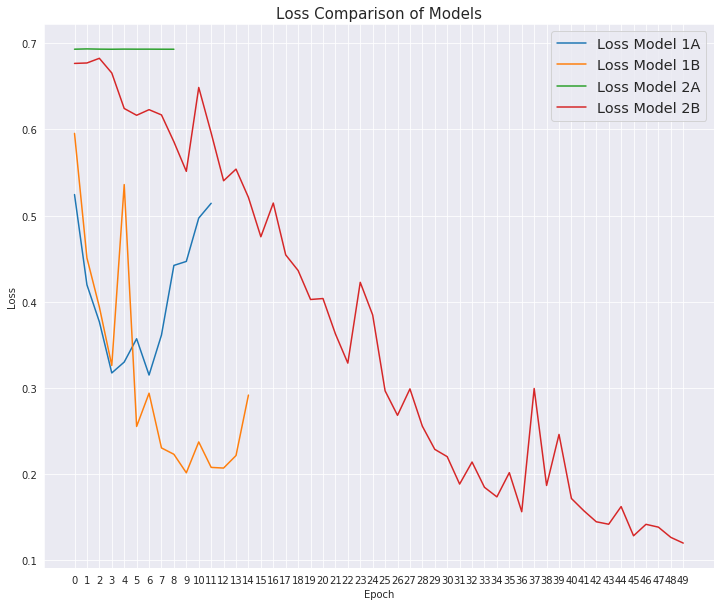

In [0]:
#Plot validation loss for all models
fig, ax = plt.subplots(figsize=(12,10))
ax.plot(val_loss_1A, label='Loss Model 1A')
ax.plot(val_loss_1B, label='Loss Model 1B')
ax.plot(val_loss_2A, label='Loss Model 2A')
ax.plot(val_loss_2B, label='Loss Model 2B')
plt.grid(which='minor')
plt.xticks(np.arange(0, 50, step=1))
plt.ylabel('Loss')
plt.xlabel('Epoch')
legend = ax.legend(loc='best', fontsize='x-large' )
plt.title('Loss Comparison of Models', fontsize='15')
plt.show();

**F1 Scores, Precision, Recall:**
 - Curves in each plot below are similar to the accuracy curves with the exception of model 2A, which shows how the model struggled to come to an optimal solution. This is evident when examining the recall curve for model 2A, as it goes from 100% recall all the way down to 0%.

**F1 Comparison of Models:**

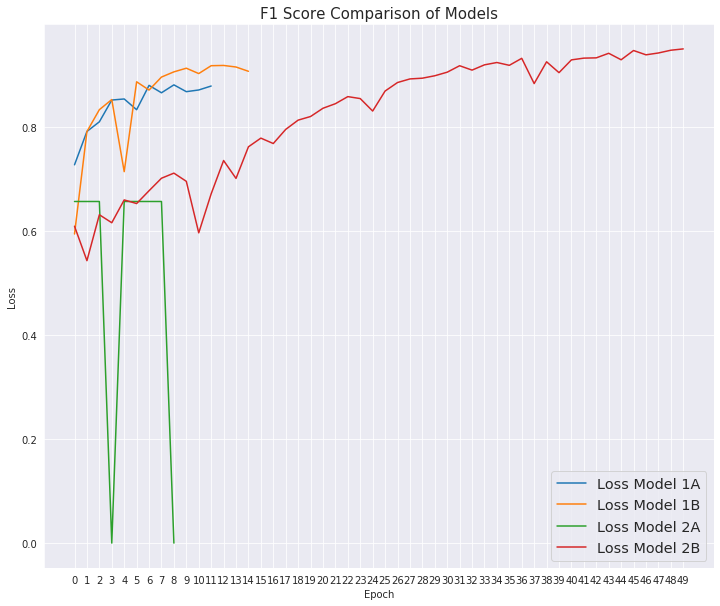

In [0]:
#Plot F1 score loss for all models
fig, ax = plt.subplots(figsize=(12,10))
ax.plot(val_f1_1A, label='Loss Model 1A')
ax.plot(val_f1_1B, label='Loss Model 1B')
ax.plot(val_f1_2A, label='Loss Model 2A')
ax.plot(val_f1_2B, label='Loss Model 2B')
plt.grid(which='minor')
plt.xticks(np.arange(0, 50, step=1))
plt.ylabel('Loss')
plt.xlabel('Epoch')
legend = ax.legend(loc='best', fontsize='x-large' )
plt.title('F1 Score Comparison of Models', fontsize='15')
plt.show();

**Precision Comparison of Models:**

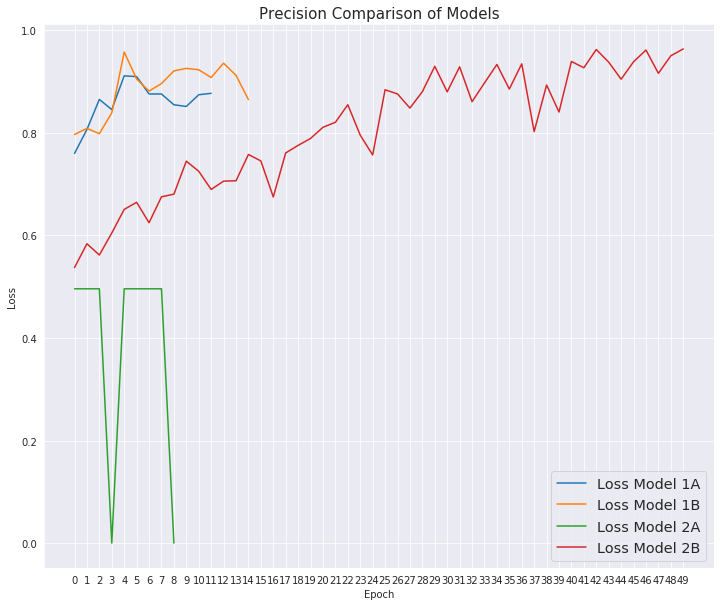

In [0]:
#Plot validation precision for all models
fig, ax = plt.subplots(figsize=(12,10))
ax.plot(val_precision_1A, label='Loss Model 1A')
ax.plot(val_precision_1B, label='Loss Model 1B')
ax.plot(val_precision_2A, label='Loss Model 2A')
ax.plot(val_precision_2B, label='Loss Model 2B')
plt.grid(which='minor')
plt.xticks(np.arange(0, 50, step=1))
plt.ylabel('Loss')
plt.xlabel('Epoch')
legend = ax.legend(loc='best', fontsize='x-large' )
plt.title('Precision Comparison of Models', fontsize='15')
plt.show();

**Recall Comparison of Models:**

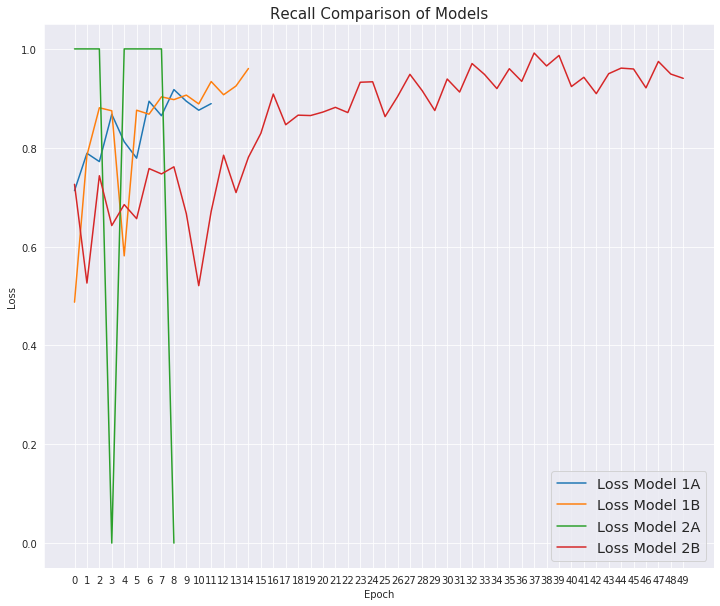

In [0]:
#Plot validation recall for all models
fig, ax = plt.subplots(figsize=(12,10))
ax.plot(val_recall_1A, label='Loss Model 1A')
ax.plot(val_recall_1B, label='Loss Model 1B')
ax.plot(val_recall_2A, label='Loss Model 2A')
ax.plot(val_recall_2B, label='Loss Model 2B')
plt.grid(which='minor')
plt.xticks(np.arange(0, 50, step=1))
plt.ylabel('Loss')
plt.xlabel('Epoch')
legend = ax.legend(loc='best', fontsize='x-large' )
plt.title('Recall Comparison of Models', fontsize='15')
plt.show();

**CNN Benchmark Experiment Results:**
 - An overview of the processing times, training accuracy, test accuracy, and average loss indicate that the best choices would most likely be between the second models from the first and second experimental factors. 
 - One factor to consider is that while the second model in the second experimental factor performed the best, the processing time showed about a 160% difference from the second model in the first experimental factor. Yet the difference in accuracy was around 3.5% higher, which can make a strong impact, especially when it comes down to image classification. Additionally, validation loss had a difference of around 51%. This makes a significant difference if accuracy and loss are of significant importance as the trade-off between these performance metrics and overall performance cannot be ignored. This must be taken into careful consideration.
 - It is also worth noting that the first model in the first experimental factor had a difference in accuracy by about 3.28%, and a difference in 44% in loss, yet was 48.18% faster. As the parameters were about the same aside from batch normalization and regularization using dropout, it may be worthwile to use the first model, and adjust the nodes and layers before performing regularization tasks. This would cut down on valuable time and resources.
 - Due to an error in processing test set predictions, evalution results are not covered.   

**Revised Kaggle Results:**
 - Model 1A: 0.31807
 - Model 1B: 0.24161
 - Model 2B: 0.16910

In [0]:
#Table for benchmark comparison
comparison_df = pd.DataFrame(np.array([['Model 1A', '13',  round(exec_time_model_1a, 2), round(stats_val_1A[1], 5), round(stats_val_1A[0], 5), Test_1A],
                                       ['Model 1B', '14',  round(exec_time_model_1b, 2), round(stats_val_1B[1], 5), round(stats_val_1B[0], 5), Test_1B],
                                       ['Model 2A', '15',  round(exec_time_model_2a, 2), round(stats_val_2A[1], 5), round(stats_val_2A[0], 5), Test_2A],
                                       ['Model 2B', '22',  round(exec_time_model_2b, 2), round(stats_val_2B[1], 5), round(stats_val_2B[0], 5), Test_2B]]),
                                      columns=('Model', 'Total CNN Layers', 'Processing Time in Minutes', 
                                               'Training Set Accuracy', 'Training Loss', 'Test Set Loss'))
comparison_df

,Model,Total CNN Layers,Processing Time in Minutes,Training Set Accuracy,Training Loss,Test Set Loss
0,Model 1A,13,13.75,0.88464,0.31606,3.69541
1,Model 1B,14,22.63,0.91744,0.2016,3.0692
2,Model 2A,15,32.03,0.50368,0.69313,0.69318
3,Model 2B,22,207.64,0.95248,0.11995,3.15518


**Benchmark Processing Time Comparison by Model:**

  - By examining the plot of processing times by model, except for the second model in the second experimental factor, from a high level view, all times do not seem to be significantly different.
  - As detailed in the above, although performance times are something that needs to be taken into careful consideration, other factors must also be weighed in, especially with neural networks, which require detailed attention to the preprocessing of data, topology, and hyperparameter settings.


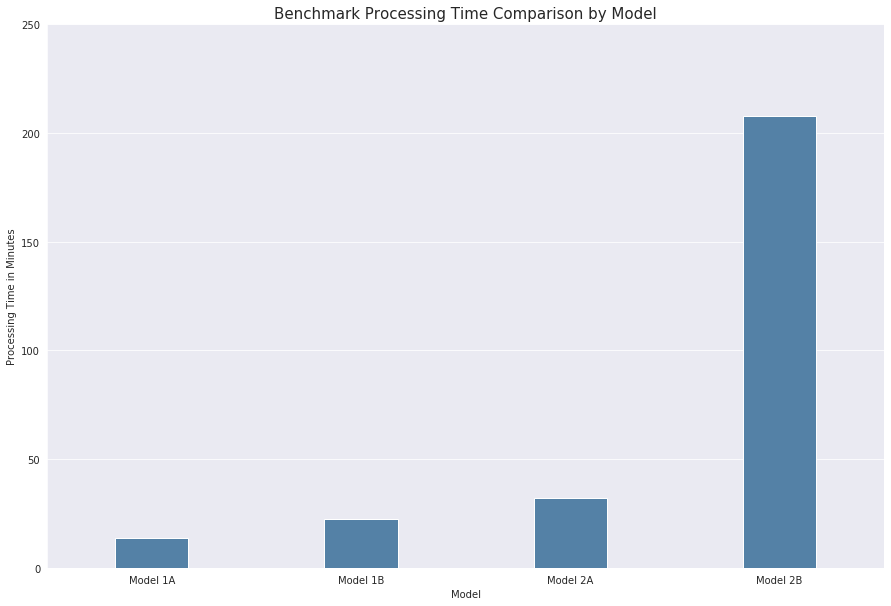

In [0]:
#Plot of model processing times:
comparison_df['Processing Time in Minutes'] = comparison_df['Processing Time in Minutes'].astype(float) 
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot('Model', 'Processing Time in Minutes', data = comparison_df, color='steelblue')

def change_width(ax, new_value) : #Change width of bars
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .35)

plt.ylim(0, 250)
plt.title('Benchmark Processing Time Comparison by Model', fontsize='15')
plt.show();

### **Conclusion:**
*  In this experiment, a Dogs versus Cats data set was used. The data set contained data for thousands of color images for dogs and cats. 
* Multiple convolutional neural networks were built and tested to classify the images in the dataset. Train and test set accuracies and losses were captured, as well as processing times for training each model. The number of layers and nodes per layer served as key parameters that differentiated each model, and the accuracies, loss, and processing times were be compared. Log loss was the main metric used to compare models. 
* Each image was a part of 2 folders, one for training and the other for testing. Images in the training folder had labels as a part of the file name.
* The training folder contained 25,000 images of dogs and cats. The test folder contained 12,500 images, named according to a numeric id [2].
* For each image in the test set, a probability was predicted for dogs and cats.
*  Image classifiers were developed using convolutional layers and max pooling layers that were used to predict the probability of which of the images was a cat or a dog.
*   The goal of this benchmark experiment was to assess the effectiveness of convolutional neural networks using different topologies. 
*   Benchmark experiment was based on a 2x2 factorial design with two levels on each of two experimental factors. 
* Models were evaluated on the test set that were scored by a third party (Kaggle).
- Accuracy scores over epochs showed that models 1B and 2B of both experimental factors were significantly better than their counterparts.
- This is likely due to the application of batch normalization and regularization using dropouts.
- However, model 1B showed a decrease after the 13th epoch, and if it had not been stopped through early stopping, it is presumable that accuracy would have continued to fall. This was also supported by examining loss, as it began to increase after the 13th epoch.
- Although model 2B stopped training after the 50th epoch, this was not due to early stopping. It is assumed that this would have continued to increase. Due to lack of time and computing resources, this could not be further explored.
- Model 2A had difficulty in converging to an optimal solution. It was not able to train over the data properly, which was a sign of a vanishing gradients problem.
- The model with the lowest loss was the second model in the second experimental factor.
- Curves show that there was a continued decrease over epochs showing signs that it would continue if the model trained over more epochs.
- However, the processing time for model 2B was over 3 hours where it had a loss that was .08165 less than model 1B. On the other hand, the percentage difference is about 51%. This trade-off should be carefully considered.
- An overview of the processing times, training accuracy, test accuracy, and average loss indicated that the best choices would most likely be between the second models from the first and second experimental factors. 
- One factor to consider is that while the second model in the second experimental factor performed the best, the processing time showed about a 160% difference from the second model in the first experimental factor. Yet the difference in accuracy was around 3.5% higher, which can make a strong impact, especially when it comes down to image classification. Additionally, validation loss had a difference of around 51%. This makes a significant difference if accuracy and loss are of utmost importance as the trade-off between these performance metrics and overall performance cannot be ignored. This must be taken into careful consideration.
- It is also worth noting that the first model in the first experimental factor had a difference in accuracy by about 3.28%, and a difference in 44% in loss from the second model, yet was 48.18% faster. As the parameters were about the same aside from batch normalization and regularization using dropout, it may be worthwile to use the first model, and adjust the nodes and layers before performing regularization tasks. This would cut down on valuable time and resources.
- Due to an error in processing test set predictions, evaluation results were not covered.  
- Although performance times are something that needs to be taken into careful consideration, other factors must also be weighed in, especially with neural networks, which require detailed attention to the preprocessing of data, topology, and hyperparameter settings
- In the case of image processing for automated image labeling provided by end users over the internet, it is critical that the utmost accuracy is maintained. Based on the results of this experiment, a model similar to the second model in the second experimental factor is recommended. That is, a model with a topology that has a complex highly regularized architecture that is similar to VGG16, or some other variant, is the most suitable for our needs. While it is a model that takes longer to train requiring more time and resources, for projects that require achieving the highest possible accuracy, it would be in our benefit to employ such endeavors. In this experiment, multiple convolutional layers, pooling layers, and fully connected layers were employed to model different convolutional neural networks. Adam optimization was utilized where a ReLu activation function was used for the convolutional layers and fully connected layers, and a sigmoid activation function was used for the output layer using binary cross entropy as a cost function. Max pooling, average pooling, and global average pooling were also utilized. Other hyperparameter settings included a dropout rate that was either set to 0.25 or 0.50, epochs were set to 50, batch sizes were set at 32, with 585 steps per epoch for training, and 195 steps for validation. Early stopping was also used with a stopping parameter based on validation loss, stopping between 5 to 8 epochs after the least amount of loss was determined. It is recommended that the number of epochs are raised in the case of using a VGG16 like architecture, and these hyperparameter settings are used until further experiments are conducted where other topologies, hyperparameter settings, and methods can be explored. 


### References:
[1] Géron, A. (2017). Hands-on machine learning with Scikit-Learn & TensorFlow: Concepts, tools, and techniques to build intelligent systems. Sebastopol, CA: O’Reilly.

[2] https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data

[3] https://www.tensorflow.org/tutorials/images/classification 